In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scanpy as sc
from tqdm import tqdm

import sys
#show the pass to chocolat module
sys.path.append('../')
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# Load experiment anndata objects

andata_folder = '../data/composed_anndata_objects_2024_01_30'

# List all files in the 'tidy' folder
file_list = os.listdir(andata_folder)

adata_dict = {}
for file in file_list:
    if file.endswith('.h5ad'):
        ref_code = file[:-5]  # Remove the '.h5ad' extension
        
        filepath = os.path.join(andata_folder, file)
        adata = sc.read_h5ad(filepath)
        adata.obsm['spatial'] = adata.obsm['spatial'].astype(int) # To ensure spatial coordinates are numerical
        adata.obs['histo_annotation_num'][[str(x).startswith("Normal") for x in adata.obs['histo_annotation_num']]] = 'NaN' # Remove normal annotation from numberical ids
        adata_dict[ref_code] = adata

In [3]:
# Load filtere anndata objects

filtered_anndata_folder = '../data/filtered-anndata'
file_list = os.listdir(filtered_anndata_folder)

adata_dict_filtered = {}
for file in file_list:
    if file.endswith('.h5ad'):
        ref_code = file[:-5]  # Remove the '.h5ad' extension
        
        filepath = os.path.join(filtered_anndata_folder, file)
        adata = sc.read_h5ad(filepath)
        adata.obsm['spatial'] = adata.obsm['spatial'].astype(int) # To ensure spatial coordinates are numerical
        adata_dict_filtered[ref_code] = adata

In [4]:
# Load inferred perturbations probability posteriors

# Load saved model samples
with open('../data/model_outputs/samples_genotyping_model.npy', 'rb') as file:
    samples_dict = np.load(file, allow_pickle=True).item()

In [5]:
# Load plasmid encoding table

plasmids_df = pd.read_csv('../data/plasmid_code.csv')
plasmids_matrix = pd.pivot_table(plasmids_df, index='List', columns='Name', values='FeatureType',
                                 aggfunc=lambda x: 1, fill_value=0)
reporters = list(plasmids_matrix.columns)

plasmids_ordered_list = ['MYC-plasmid', 'mtCtnnb1', 'coVEGFA-plasmid',
                         'shMLL3-plasmid', 'NICD-plasmid', 'shRen-plasmid', 'shtrp53-plasmid', 'shPTEN-plasmid']

colours = {
    "MYC-plasmid": "#56b4e9",  # Blue
    "coVEGFA-plasmid": "#cc79a7",  # Orange
    "NICD-plasmid": "#e69f00",  # Green
    "shRen-plasmid": "#f0e442",  # Red
    "shtrp53-plasmid": "#d55e00",  # Purple
    "shPTEN-plasmid" : "#009e73",  # Brown
    "shMLL3-plasmid": "#0072b2",  # Pink
    "mtCtnnb1": "#000000",  # Grey
}

## Plot Tumour phenotype and TME

In [6]:
from chocolat.plt import create_colormap, plot_spatial_cell_signature

In [7]:
keys_6ROI = ['ML_I_2', 'ML_II_B', 'ML_II_C', 'ML_III_A', 'ML_III_B', 'ML_II_A_1']


6it [00:28,  4.73s/it]


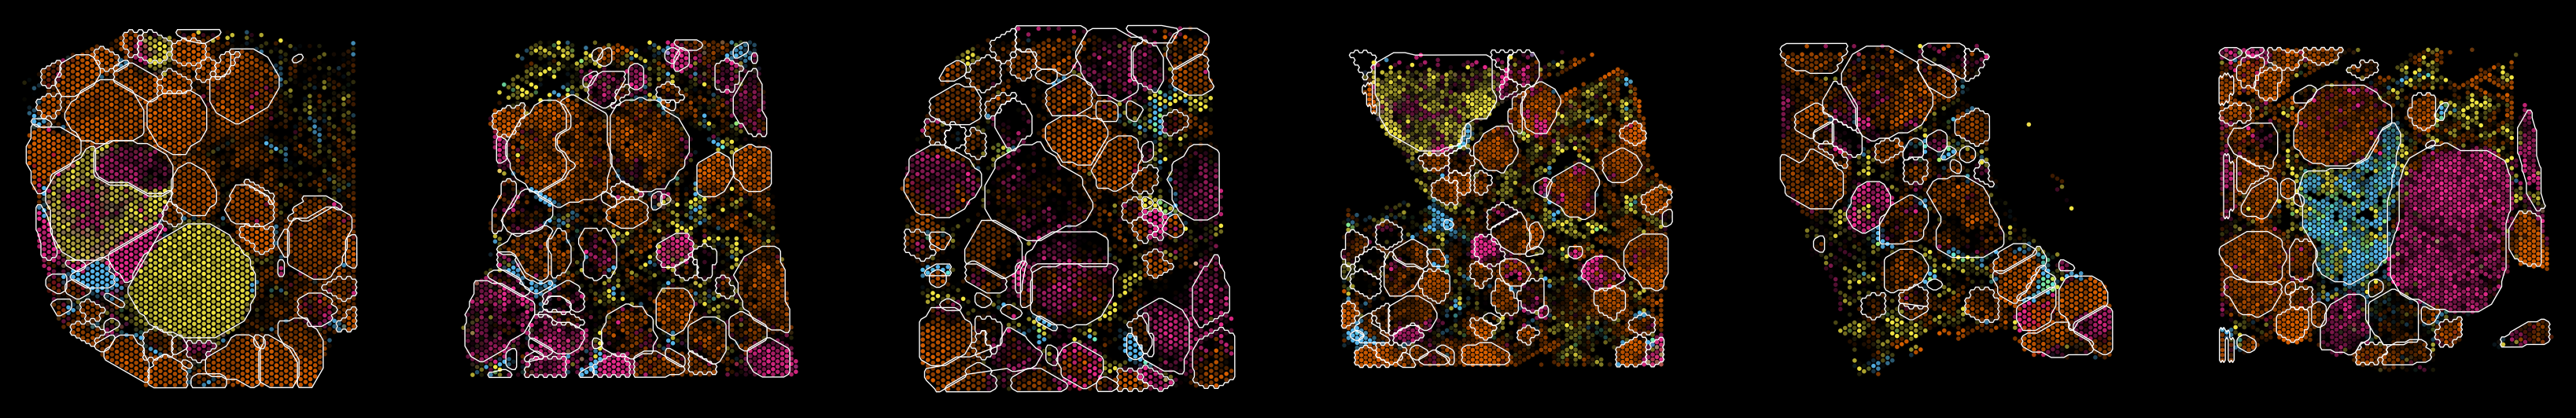

In [8]:
### Tumour instrinisc subtypes
# outlines take a few mintues to compute

YellowCM = create_colormap(240, 228, 66, 25)  
RedCM = create_colormap(213, 94, 0, 25)  
BlueCM = create_colormap(86, 180, 233, 25) 
PinkCM = create_colormap(230, 42, 138, 25) 

tumor_genes = {
    "Periportal HC": ["Sds", "Sdsl", "Hal"],
    "Pericentral HC": ["Oat", "Gulo", "Cyp2e1", "Cyp1a2"],
    "Cholangiocytic": ["Krt19", "Cldn7", "Krt7", "Mapk13", "Epcam"],
    "Midlobular/Other": ["Hamp", "Hamp2", "Car3", "Upp2"],
    # "Histone": ["Hist1h3d","Hist1h2ag", "Hist1h1c", "Hist1h1e", "Hist1h4h", "Hist1h3c"],
}

fig, axs = plt.subplots(1,len(keys_6ROI), figsize=(7*len(keys_6ROI),7))
fig.patch.set_facecolor('black')
for c, k in tqdm(enumerate(keys_6ROI)):
    adata = adata_dict[k].copy()
    sc.pp.normalize_total(adata, 1e4)
    sc.pp.log1p(adata)
    plot_spatial_cell_signature(adata, tumor_genes, pmin=25, pmax=99, s=4, outline=True, ax=axs[c], cmaps = [YellowCM, RedCM, BlueCM, PinkCM], rasterised=True)

6it [00:29,  4.88s/it]


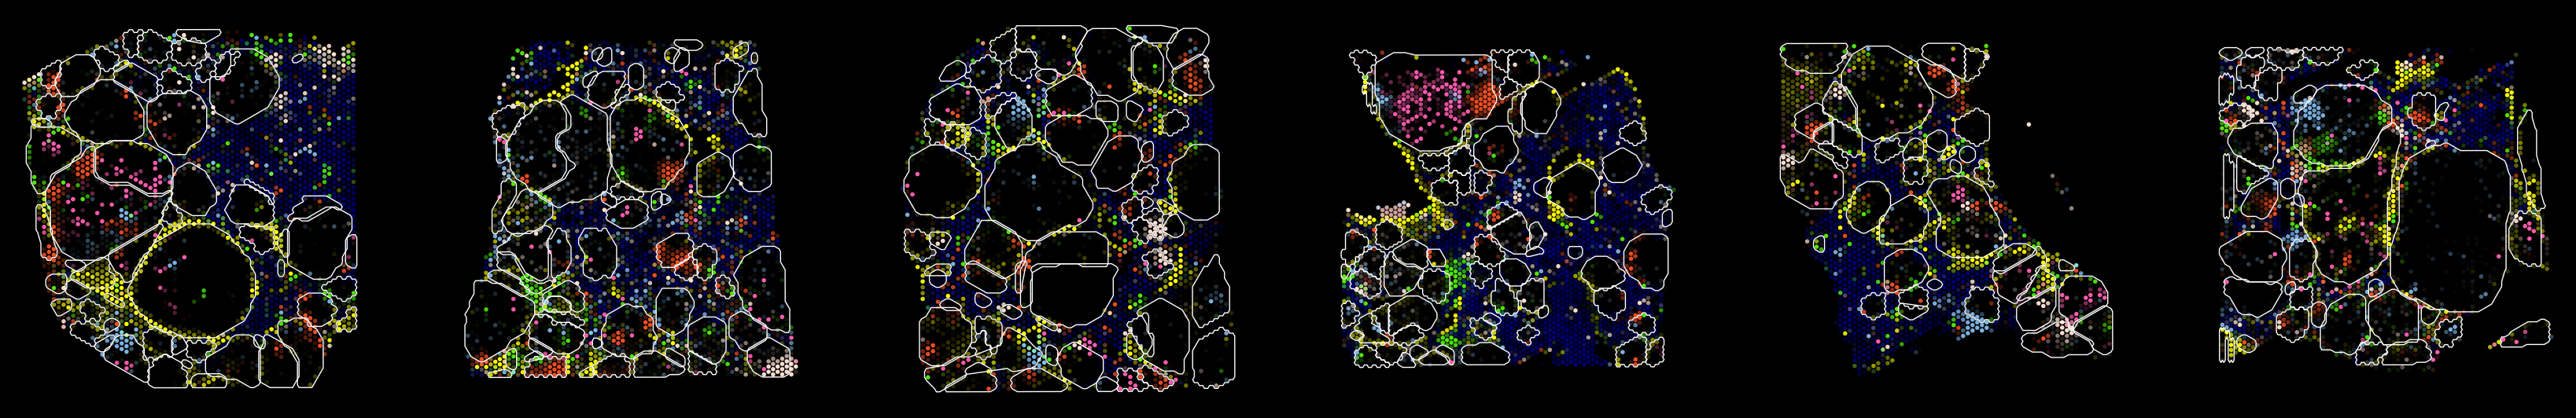

In [9]:
### Tumour microenvironemnt
# outlines take a few mintues to compute

FibroblastsCM = create_colormap(255, 255, 0, 25)
ErythrocytesCM = create_colormap(239, 78, 34, 25)
KupffercellsCM = create_colormap(0, 0, 117, 25)
NeutrophilsCM = create_colormap(123, 175, 222, 25)
PlateletsCM = create_colormap(249, 222, 207, 25)
BcellsCM = create_colormap(79, 227, 11, 25)
MastcellsCM = create_colormap(254, 91, 172, 25)
PeriportalHCCCM = create_colormap(199, 34, 40, 25)
PericentralHCCCM = create_colormap(250, 203, 18, 25)
CholangiocytesCM = create_colormap(50, 168, 166, 25)

tme_genes = {
      "Fibroblasts"  : ["Col1a1", "Col3a1", "Col1a2", "Col5a1", "Dpt"],
      "Erythrocytes" : ["Hbb-bt", "Hba-a2", "Alas2", "Tmcc2", "Slc4a1"],
      "Mast cells"   : ["Cpa3", "Cma1", "Tpsb2", "Mcpt4", 'Tpsab1'],
      "Neutrophils"  : ["S100a9", "S100a8", "Ngp", "Ltf", "Camp", "Elane", "Ctsg", "Mpo"],
      "Platelets"    : ["Pf4", "Itga2b", "Ppbp"],
      "B cells"      : ["Igkc", "Jchain"],
      "Kupffer cells": ["Clec4f", "Csf1r", "Marco", "Cd163"],
}

fig, axs = plt.subplots(1,len(keys_6ROI), figsize=(7*len(keys_6ROI),7))
fig.patch.set_facecolor('black')
for c, k in tqdm(enumerate(keys_6ROI)):
    adata = adata_dict[k].copy()
    sc.pp.normalize_total(adata, 1e4)
    sc.pp.log1p(adata)
    plot_spatial_cell_signature(adata, tme_genes, pmin=25, pmax=99, s=4, outline=True, ax=axs[c], cmaps = [FibroblastsCM, ErythrocytesCM, MastcellsCM, NeutrophilsCM, PlateletsCM, BcellsCM, KupffercellsCM], rasterised=True)


## Phenotype based grouping for genotypes

In [10]:
from chocolat.plt import plot_genotype_enrichment_OR

In [11]:
import pickle as pkl
with open('../data/model_outputs/plasmid_probs-all-samples-final.pkl', 'rb') as f:
    obs_dict = pkl.load(f)
adata_geno_nodule = sc.read_h5ad('../data/geno_nodule_aggregated_2024_04_03.h5ad')
df_dat_alt = adata_geno_nodule.obs.loc[:,['sample', 'number', 'batch']+
                                       list(np.array(list(adata_geno_nodule.obs.columns))[[x.endswith('bin')
                                                                                           for x in adata_geno_nodule.obs.columns]])]
df_dat_alt = df_dat_alt[~np.array([s.startswith('Normal') for s in df_dat_alt['number']])]
df_dat_alt = df_dat_alt[df_dat_alt['batch'].isin(keys_6ROI)]

In [12]:
df_dat = pd.DataFrame(obs_dict['probs'], columns=obs_dict['plasmids'],
                 index=[s+'::'+n for n, s in zip(obs_dict['names'],
                                                obs_dict['samples'])])

df_dat = df_dat[[x.split('::')[0] in keys_6ROI for x in df_dat.index]]

common_ids = list(set(df_dat.index).intersection(df_dat_alt.index))
df_dat_alt = pd.concat([df_dat.loc[common_ids], df_dat_alt.loc[common_ids]], axis=1)

# df_dat_alt = df_dat_alt[~np.array([s.startswith('Normal') for s in df_dat_alt['number']])]

5it [00:11,  2.21s/it]


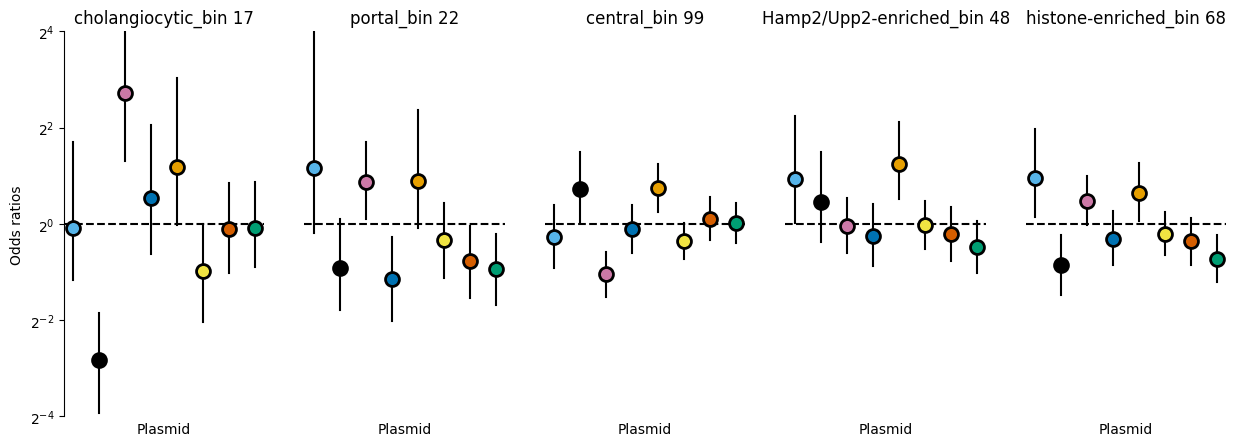

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(3*5, 5))
for i, k in tqdm(enumerate(['cholangiocytic_bin', 'portal_bin', 'central_bin',
       'Hamp2/Upp2-enriched_bin', 'histone-enriched_bin'])):
    plot_genotype_enrichment_OR(df_dat_alt, k, ax=ax[i], plasmid_list=plasmids_ordered_list)
    if i != 0:
        ax[i].set_yticks([])
        ax[i].set_yticklabels([])
        ax[i].spines[['left']].set_visible(False)
        ax[i].set_ylabel(None)

5it [00:11,  2.23s/it]


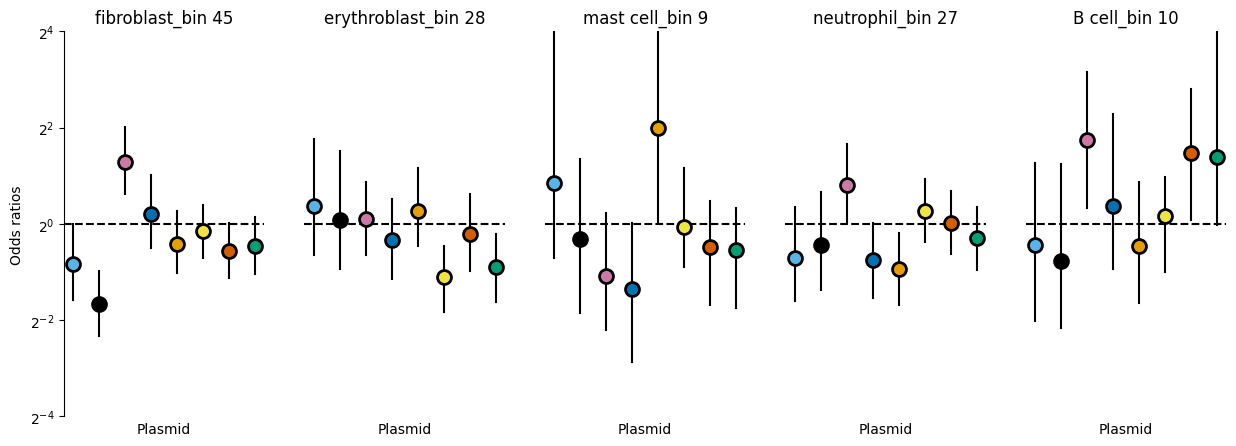

In [14]:
np.random.seed(42)
fig, ax = plt.subplots(1, 5, figsize=(3*5, 5))
for i, k in tqdm(enumerate(['fibroblast_bin',
       'erythroblast_bin', 'mast cell_bin', 'neutrophil_bin',
       'B cell_bin'])):
    plot_genotype_enrichment_OR(df_dat_alt, k, ax=ax[i], plasmid_list=plasmids_ordered_list)
    if i != 0:
        ax[i].set_yticks([])
        ax[i].set_yticklabels([])
        ax[i].spines[['left']].set_visible(False)
        ax[i].set_ylabel(None)

## Predicting phenotypes based on the genotypes (GLMM)

In [15]:
from chocolat.models import ModelGlmmPoisson, GuideGlmmPoisson, prepare_data4glmm, train_glm_models, get_model_weights_array
from chocolat.plt import plot_heatmap_cutouts

/lustre/scratch127/casm/team299ly/al15/miniconda3/envs/chocolat-g2p/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
keys_6ROI = ['ML_III_A', 'ML_III_B', 'ML_II_A_1',
           'ML_II_B',
           'ML_II_C', 'ML_I_2']


gene_sets = [set(adata_dict_filtered[k].var.index) for k in keys_6ROI]
common_genes = set.intersection(*gene_sets)
common_gene_list = list(common_genes)
gene_expressed = np.array(common_gene_list)[np.sum([(np.log1p(np.array(adata_dict_filtered[k][~adata_dict_filtered[k].obs['histo_annotation'].isna(), common_gene_list].X.todense()).sum(0)) > 4)
                                                    & (np.log1p(np.array(adata_dict_filtered[k][~adata_dict_filtered[k].obs['histo_annotation'].isna(), common_gene_list].X.todense()).sum(0)) < 12)
                  for k in keys_6ROI], 0) == 6]

In [17]:
tme_genes = {
      "Fibroblasts"  : ["Col1a1", "Col3a1", "Col1a2", "Col5a1", "Dpt"],
      "Erythrocytes" : ["Hbb-bt", "Hba-a2", "Alas2", "Tmcc2", "Slc4a1"],
      "Mast cells"   : ["Cpa3", "Cma1", "Tpsb2", "Mcpt4", 'Tpsab1'],
      "Neutrophils"  : ["S100a9", "S100a8", "Ngp", "Ltf", "Camp", "Elane", "Ctsg", "Mpo"],
      "Platelets"    : ["Pf4", "Itga2b", "Ppbp"],
      "B cells"      : ["Igkc", "Jchain"],
      "Kupffer cells": ["Clec4f", "Csf1r", "Marco", "Cd163"],
}


tumor_genes = {
    "Periportal HC": ["Sds", "Sdsl", "Hal"],
    "Pericentral HC": ["Oat", "Gulo", "Cyp2e1", "Cyp1a2"],
    "Cholangiocytic": ["Krt19", "Cldn7", "Krt7", "Mapk13", "Epcam"],
    "Midlobular/Other": ["Vil1", "Hamp2", "Car3", "Upp2"],
    "Histone": ["Hist1h3d","Hist1h2ag", "Hist1h1c", "Hist1h1e", "Hist1h4h", "Hist1h3c"],
}

combined_gene_list = [x for v in tme_genes.values() for x in v] + [x for v in tumor_genes.values() for x in v]

combined_gene_list = list(set(gene_expressed) | set(combined_gene_list))

In [18]:
observations_dict = {}
for key in keys_6ROI:
    observations_dict[key] = np.array(adata_dict_filtered[key][:,combined_gene_list].X.todense())

In [19]:
(prior_parametrisation_tensor_dict, region_indices_stacked,
 sample_indices_by_region, sample_indices_stacked, 
 observations_tensor, observations_by_region) = prepare_data4glmm(adata_dict_filtered, samples_dict, observations_dict, keys=keys_6ROI)

mean_marginal, variance_marginal, loss_list = train_glm_models(prior_parametrisation_tensor_dict,
                                                               region_indices=region_indices_stacked,
                                                               sample_indices=sample_indices_stacked,
                                                               observations_tensor=observations_tensor,
                                                               obs=observations_tensor,
                                                               model=ModelGlmmPoisson,
                                                               guide=GuideGlmmPoisson,
                                                               num_iters=5000,
                                                               device='cuda')

using cuda


/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inferred_spot_sensitivity = torch.tensor(inferred_spot_sensitivity, device=device)
/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inferred_region_params = torch.tensor(inferred_region_params, device=device)
/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

In [22]:
### To save and load data

# saved_params = {'mean_marginal': mean_marginal, 'variance_marginal': variance_marginal}

# import pickle as pkl
# with open('../data/model_outputs/expression_clean_run_-3.pkl', 'wb') as file:
#     pkl.dump(saved_params, file)
    
# import pickle as pkl

# with open('../data/model_outputs/expression_clean_run_-3.pkl', 'rb') as file:


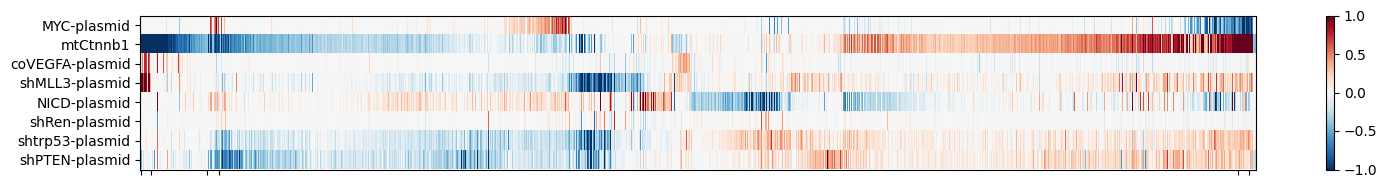

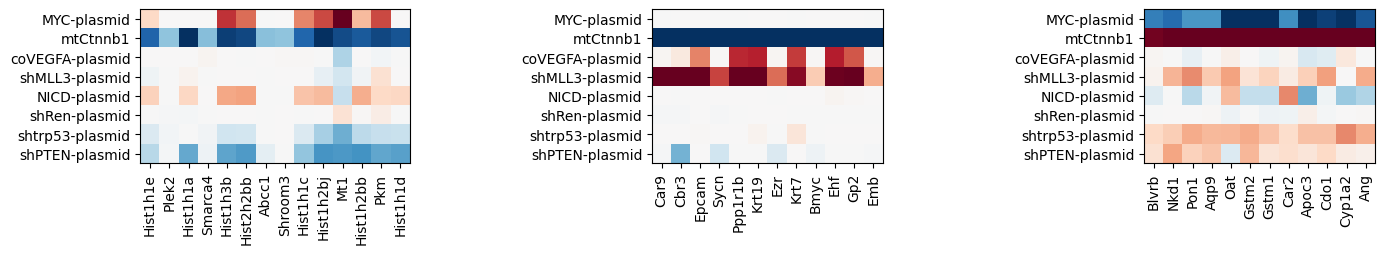

In [23]:
data_matrix, data_names = get_model_weights_array(mean_marginal, variance_marginal, combined_gene_list, remove_genes=plasmids_df.Name)

plt.figure(figsize=(18,2))
plt.imshow(data_matrix, aspect='auto', cmap='RdBu_r', vmax=1, vmin=-1, interpolation='none')
plt.yticks(np.arange(len(plasmids_ordered_list)), np.array(plasmids_ordered_list)[:]);
#show which regions were zoomed in; if you rerun code, these may change
plt.xticks([data_names.index(x) for x in ['Hist1h1e', 'Hist1h1d', 'Car9', 'Emb', 'Blvrb', 'Ang']],
           []);
cb = plt.colorbar()

fig, axs = plt.subplots(1,3,figsize=(18,2))
plot_heatmap_cutouts(data_matrix, data_names, gene_name='Hist1h1a', l=2, r=12, ax=axs[0])
plot_heatmap_cutouts(data_matrix, data_names, gene_name='Krt19', l=5, r=7, ax=axs[1])
plot_heatmap_cutouts(data_matrix, data_names, gene_name='Oat', l=4, r=8, ax=axs[2])

axs[0].set_yticks(np.arange(len(plasmids_ordered_list)))
axs[0].set_yticklabels(plasmids_ordered_list)
axs[1].set_yticks(np.arange(len(plasmids_ordered_list)))
axs[1].set_yticklabels(plasmids_ordered_list)
axs[2].set_yticks(np.arange(len(plasmids_ordered_list)))
axs[2].set_yticklabels(plasmids_ordered_list);